<a href="https://colab.research.google.com/github/sjc4197/whiky_wiki/blob/main/Whiki_wiki_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q /content/drive/MyDrive/test_whisky_data.zip

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
from PIL import Image
import numpy as np
import csv

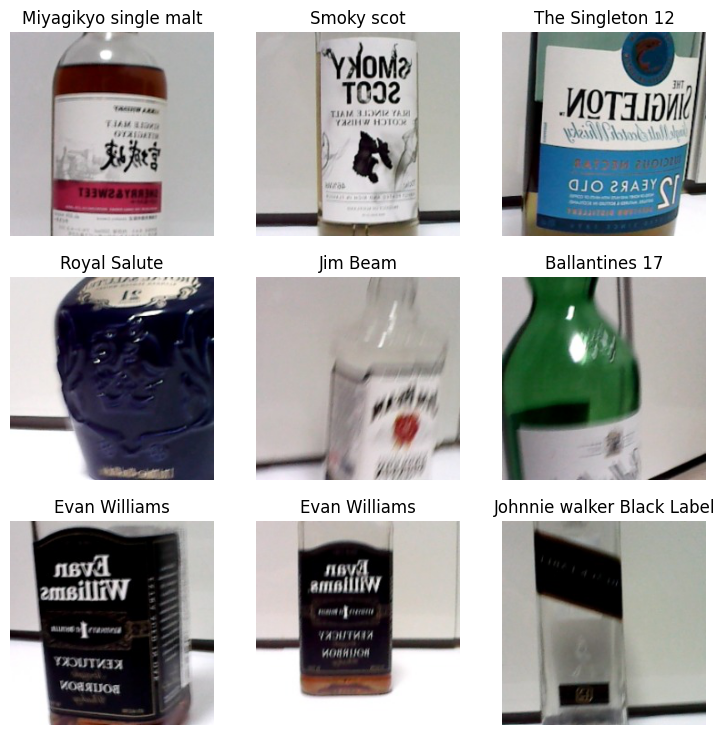

In [ ]:
path = 'test_whisky_data'

block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
)

loader = block.dataloaders(path)

loader.show_batch()

In [ ]:
learn = vision_learner(loader, resnet34, metrics=accuracy)

learn.fine_tune(epochs = 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 262MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.317334,0.019483,0.995093,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.025649,0.006549,0.998112,00:58
1,0.002892,0.000585,0.999623,00:57
2,0.000602,0.000291,1.000000,00:57


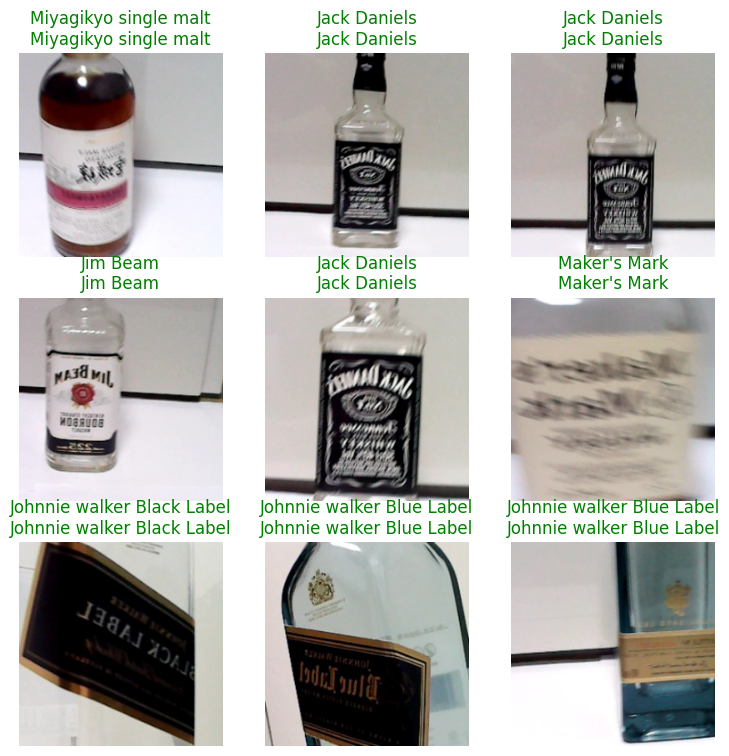

In [ ]:
learn.show_results()

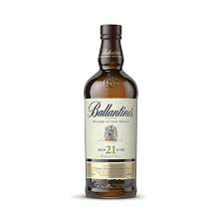

In [ ]:
img = Image.open('/content/__MACOSX/dkdhtlqkf.jpeg')

img_resized = img.resize((224,224))

img_resized.show()

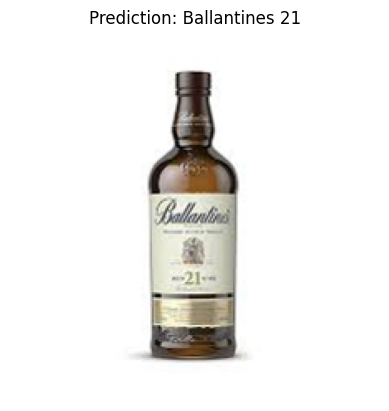

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img_resized)

plt.imshow(img_resized)
plt.title(f"Prediction: {pred_class}")
plt.axis('off')
plt.show()

In [ ]:
print(type(pred_class))

<class 'fastai.data.transforms.Category'>


torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


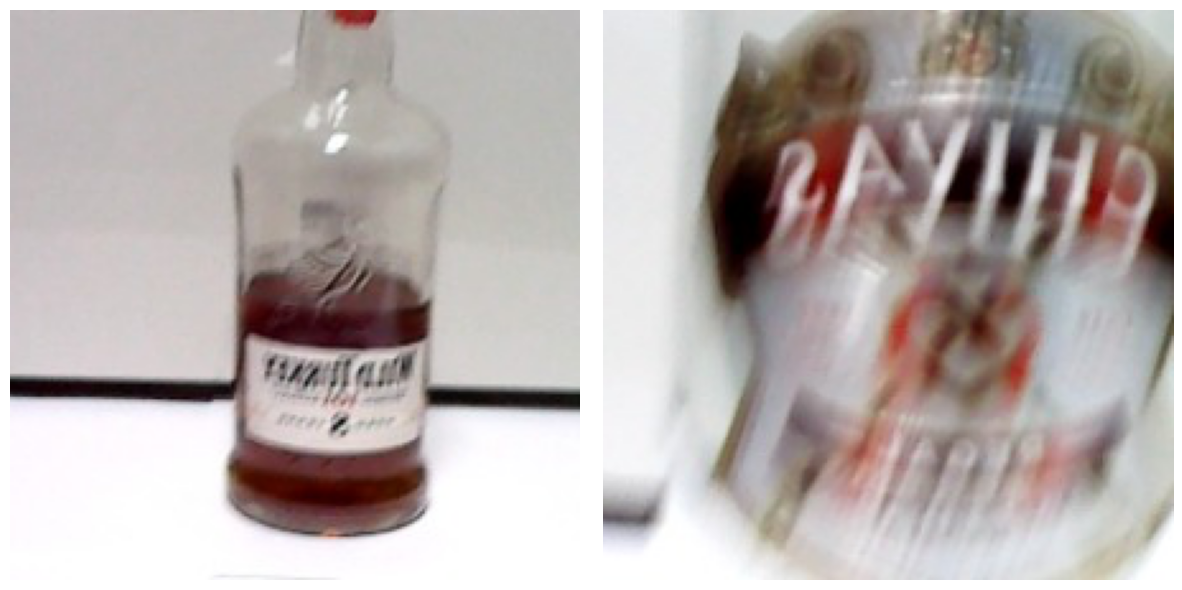

In [ ]:
Wild_Turkey_path = '/content/test_whisky_data/Wild Turkey/664.jpg'
Chivas_Regal_path = '/content/test_whisky_data/Chivas Regal/1.jpg'

test_loader = loader.test_dl([Wild_Turkey_path,Chivas_Regal_path])

Wild_Turkey_x, Chivas_Regal_x = next(iter(test_loader))[0]

Wild_Turkey_samples_x = Wild_Turkey_x.unsqueeze(0)
Chivas_Regal_samples_x = Chivas_Regal_x.unsqueeze(0)

print(Wild_Turkey_samples_x.shape, Chivas_Regal_samples_x.shape)

Wild_Turkey_img = Image.open(Wild_Turkey_path)
Chivas_Regal_img = Image.open(Chivas_Regal_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(Wild_Turkey_img)
ax[0].axis('off')
ax[1].imshow(Chivas_Regal_img)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

torch.Size([7, 7])


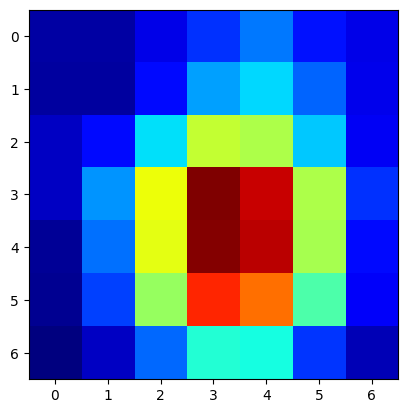

In [ ]:
def get_gradcam(x, location=-1):
    with HookBwd(learn.model[0][location]) as hookg:
        with Hook(learn.model[0][location]) as hook:
            output = learn.model.eval()(x.cuda())
            idx = torch.argmax(output)
            act = hook.stored
        output[0, idx].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1, 2], keepdim=True)
    heatmap = (w * act[0]).sum(0).detach().cpu()

    return heatmap

heatmap = get_gradcam(Wild_Turkey_samples_x, location=-1)

print(heatmap.shape)
plt.imshow(heatmap, cmap='jet')
plt.show()

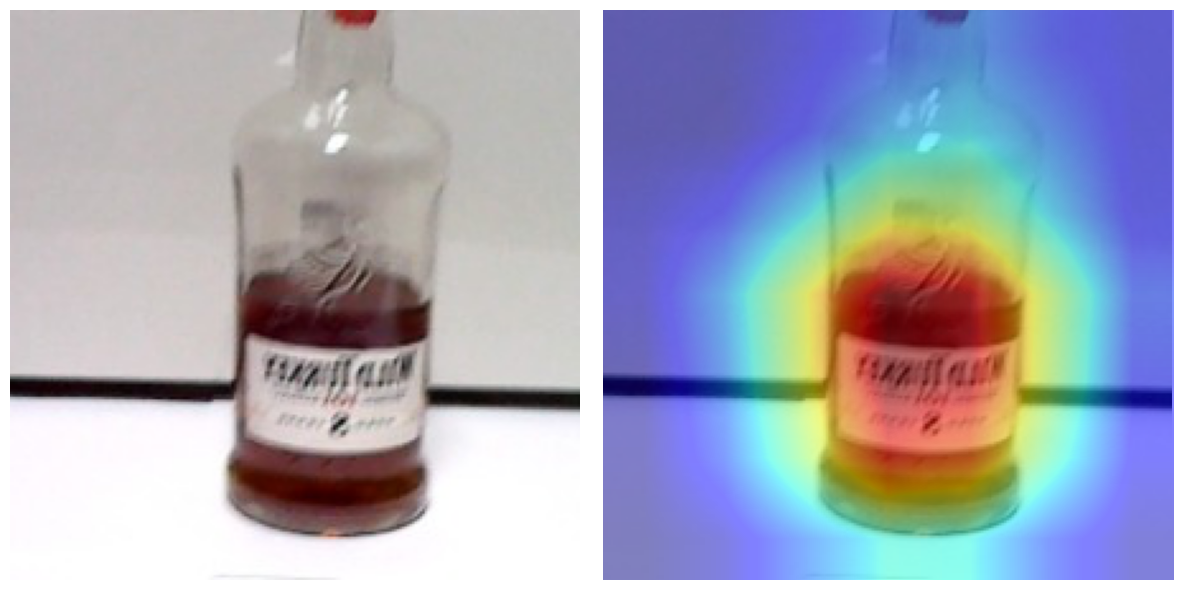

In [ ]:
img = Image.open(Wild_Turkey_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()